1.IMPORT LIBRARIES

In [9]:
# pip install -r requirements.txt

In [20]:
# Core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import MSELoss
# Data handling
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics & utilities
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Progress & debugging
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import glob
import joblib

device = "mps" if torch.backends.mps.is_available() else "cpu"


2.DATA LOADER AND CREATE SEQUENCES

In [22]:
all_files = sorted(glob.glob("data/monthly_hourly_load_values_*.xlsx"))
df_list = [pd.read_excel(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
df['DateUTC'] = pd.to_datetime(df['DateUTC'])
df.set_index('DateUTC', inplace=True)

# Training: 2019–2024, Testing: 2025
train_df_full = df[df.index.year < 2025]
test_df = df[df.index.year == 2025]

# Split validation from end of 2024 (10% of training)
val_ratio = 0.1
val_size = int(len(train_df_full) * val_ratio)
val_df = train_df_full.iloc[-val_size:]
train_df = train_df_full.iloc[:-val_size]

def create_sequences(data, seq_len=24, output_len=1):
    X, y = [], []
    for i in range(seq_len, len(data) - output_len + 1):
        X.append(data[i - seq_len:i])
        y.append(data[i:i + output_len].flatten())
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
scaler.fit(df[['Value']])
joblib.dump(scaler, 'scaler_minmax.pkl')
train_df['Value_normalized'] = scaler.transform(train_df[['Value']])
val_df['Value_normalized']   = scaler.transform(val_df[['Value']])
test_df['Value_normalized'] = scaler.transform(test_df[['Value']])


def prepare_multi_country_data_per_country_scaler(df, sequence_length=24, prediction_length=1, dataset_name="train/val"):
    """
    For each country, fit a StandardScaler, save it, and normalize values.
    """
    print(f"\n{'='*50}")
    print(f"PREPARING {dataset_name.upper()} WITH PER-COUNTRY SCALER")
    print(f"{'='*50}")

    df_clean = df.dropna(subset=['Value']).copy()
    df_clean = df_clean.sort_values(['CountryCode', 'DateUTC']).reset_index(drop=False)

    sequences = []
    targets = []
    countries = []
    timestamps = []

    for country in df_clean['CountryCode'].unique():
        country_data = df_clean[df_clean['CountryCode'] == country]
        scaler = StandardScaler()
        scaler.fit(country_data[['Value']])
        # Save scaler for later use
        scaler_filename = f"scaler_{country}.pkl"
        joblib.dump(scaler, scaler_filename)
        # Normalize values
        country_data['Value_normalized'] = scaler.transform(country_data[['Value']])
        values = country_data['Value_normalized'].values
        dates = country_data['DateUTC'].values
        X_seq, y_seq = create_sequences(values, seq_len=sequence_length, output_len=prediction_length)
        sequences.append(X_seq)
        targets.append(y_seq)
        countries.extend([country] * len(X_seq))
        timestamps.extend(dates[sequence_length:sequence_length+len(X_seq)])

    X = np.concatenate(sequences, axis=0) if sequences else np.array([])
    y = np.concatenate(targets, axis=0) if targets else np.array([])
    countries = np.array(countries)
    timestamps = np.array(timestamps)

    print(f"\nFinal dataset stats:")
    print(f"Total sequences: {len(X):,}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Normalized X range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"Normalized y range: [{y.min():.3f}, {y.max():.3f}]")

    unique_countries, counts = np.unique(countries, return_counts=True)
    print(f"\nCountry distribution in sequences:")
    for country, count in zip(unique_countries, counts):
        print(f"  {country}: {count:,} sequences ({count/len(X)*100:.1f}%)")

    return X, y

X_train, y_train = prepare_multi_country_data_per_country_scaler(
    train_df, sequence_length=24, prediction_length=1
)

X_val, y_val= prepare_multi_country_data_per_country_scaler(
    val_df, sequence_length=24, prediction_length=1
)

X_test, y_test = prepare_multi_country_data_per_country_scaler(
    test_df, sequence_length=24, prediction_length=1,dataset_name="test"
)

print(f"All datasets normalized with the same scaler")
print(f"Train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Val range:   [{X_val.min():.3f}, {X_val.max():.3f}]")
print(f"Test range:  [{X_test.min():.3f}, {X_test.max():.3f}]")





PREPARING TRAIN/VAL WITH PER-COUNTRY SCALER

Final dataset stats:
Total sequences: 1,649,186
X shape: (1649186, 24)
y shape: (1649186, 1)
Normalized X range: [-6.300, 43.175]
Normalized y range: [-6.300, 43.175]

Country distribution in sequences:
  AL: 24,912 sequences (1.5%)
  AT: 52,584 sequences (3.2%)
  BA: 47,982 sequences (2.9%)
  BE: 52,584 sequences (3.2%)
  BG: 52,584 sequences (3.2%)
  CH: 52,583 sequences (3.2%)
  CY: 27,617 sequences (1.7%)
  CZ: 52,578 sequences (3.2%)
  DE: 52,584 sequences (3.2%)
  DK: 52,583 sequences (3.2%)
  EE: 52,577 sequences (3.2%)
  ES: 52,583 sequences (3.2%)
  FI: 52,584 sequences (3.2%)
  FR: 52,519 sequences (3.2%)
  GB: 36,816 sequences (2.2%)
  GE: 25,806 sequences (1.6%)
  GR: 43,911 sequences (2.7%)
  HR: 43,800 sequences (2.7%)
  HU: 43,798 sequences (2.7%)
  IE: 38,057 sequences (2.3%)
  IT: 43,800 sequences (2.7%)
  LT: 43,798 sequences (2.7%)
  LU: 43,800 sequences (2.7%)
  LV: 43,799 sequences (2.7%)
  MD: 34,307 sequences (2.1%)
 

3.MODEL

LSTM-ATTENTION-CNN

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualBranchTFT(nn.Module):
    def __init__(self, sequence_length, prediction_length, hidden_size=64, num_layers=2, 
                 dropout=0.1, conv_kernels=[3, 7, 15], num_attention_heads=4):
        super().__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.hidden_size = hidden_size
        
        self.trend_branch = TrendExtractionBranch(
            input_size=1,
            hidden_size=hidden_size,
            conv_kernels=conv_kernels,
            dropout=dropout
        )
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_attention_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.fusion_type = "gated"  # Options: "concat", "gated", "weighted"
        
        if self.fusion_type == "concat":
            self.fusion_output_size = hidden_size * 2
            self.fusion_projection = nn.Linear(hidden_size * 2, hidden_size)
        elif self.fusion_type == "gated":
            self.fusion_gate = nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Sigmoid()
            )
            self.fusion_output_size = hidden_size
        elif self.fusion_type == "weighted":
            self.fusion_weights = nn.Parameter(torch.ones(2))  # Two branches
            self.fusion_output_size = hidden_size
        
        # Layer normalizations
        self.lstm_norm = nn.LayerNorm(hidden_size)
        self.fusion_norm = nn.LayerNorm(self.fusion_output_size)
        self.output_layer = nn.Sequential(
            nn.Linear(self.fusion_output_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, prediction_length)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1)
        batch_size = x.size(0)
        
        trend_features = self.trend_branch(x)  # (batch_size, hidden_size)
        
        # LSTM encoding
        lstm_output, (hidden, cell) = self.encoder_lstm(x)
        lstm_output = self.lstm_norm(lstm_output)
        
        # Self-attention on LSTM outputs
        attended_output, attention_weights = self.attention(
            lstm_output, lstm_output, lstm_output
        )
        
        # Get the final temporal representation (last time step)
        temporal_features = attended_output[:, -1, :]  # (batch_size, hidden_size)
        
        if self.fusion_type == "concat":
            # Simple concatenation with projection
            fused_features = torch.cat([trend_features, temporal_features], dim=-1)
            fused_features = self.fusion_projection(fused_features)
            
        elif self.fusion_type == "gated":
            # Gated fusion - learn which branch to trust more
            combined = torch.cat([trend_features, temporal_features], dim=-1)
            gate = self.fusion_gate(combined)
            fused_features = gate * trend_features + (1 - gate) * temporal_features
            
        elif self.fusion_type == "weighted":
            # Weighted sum of branches
            weights = F.softmax(self.fusion_weights, dim=0)
            fused_features = weights[0] * trend_features + weights[1] * temporal_features
        
        fused_features = self.fusion_norm(fused_features)
        
        output = self.output_layer(fused_features)  # (batch_size, prediction_length)
        
        return output


class TrendExtractionBranch(nn.Module):
    """CNN-based branch for multi-scale trend extraction"""
    
    def __init__(self, input_size, hidden_size, conv_kernels=[3, 7, 15], dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.conv_kernels = conv_kernels
        self.num_kernels = len(conv_kernels)
    
        # Use divisible allocation
        base_channels = hidden_size // self.num_kernels
        remainder = hidden_size % self.num_kernels
        self.output_channels = [base_channels + (1 if i < remainder else 0) 
                              for i in range(self.num_kernels)]
        
        # Parallel convolutional layers with different kernel sizes
        self.conv_layers = nn.ModuleList()
        for i, kernel_size in enumerate(conv_kernels):
            padding = (kernel_size - 1) // 2  # Same padding
            conv_block = nn.Sequential(
                nn.Conv1d(
                    in_channels=input_size,
                    out_channels=self.output_channels[i],
                    kernel_size=kernel_size,
                    padding=padding,
                    padding_mode='replicate'
                ),
                nn.BatchNorm1d(self.output_channels[i]),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.conv_layers.append(conv_block)
        
        # Global pooling to get trend representation
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Feature projection to ensure correct hidden_size
        self.feature_projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_size)
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1)
        # Rearrange for conv1d: (batch_size, channels, sequence_length)
        x_conv = x.transpose(1, 2)  # (batch_size, 1, sequence_length)
        
        # Apply parallel convolutions
        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_out = conv_layer(x_conv)  # (batch_size, output_channel_i, seq_len)
            conv_outputs.append(conv_out)
        
        # Concatenate along channel dimension
        combined_conv = torch.cat(conv_outputs, dim=1)  # (batch_size, hidden_size, seq_len)
        
        # Global average pooling to get trend representation
        trend_rep = self.global_pool(combined_conv)  # (batch_size, hidden_size, 1)
        trend_rep = trend_rep.squeeze(-1)  # (batch_size, hidden_size)
        
        # Final projection to ensure correct dimensions
        trend_features = self.feature_projection(trend_rep)  # (batch_size, hidden_size)
        
        return trend_features


sequence_length = 24
prediction_length = 1
hidden_size =128

# Initialize the dual-branch model
model = DualBranchTFT(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    hidden_size=hidden_size,
    num_layers=2,
    dropout=0.1,
    conv_kernels=[3, 7, 15]  # Multi-scale trend extraction
)


4.TRAINING PIPELINE

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, learning_rate=1e-4):
    """
    Simple PyTorch training function with tqdm progress bars
    """
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model.to(device)
    
    # Convert data to tensors
    if isinstance(X_train, np.ndarray):
        X_train = torch.FloatTensor(X_train)
    if isinstance(y_train, np.ndarray):
        y_train = torch.FloatTensor(y_train)
    if isinstance(X_val, np.ndarray):
        X_val = torch.FloatTensor(X_val)
    if isinstance(y_val, np.ndarray):
        y_val = torch.FloatTensor(y_val)
    
    # Create DataLoaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    print("Starting training...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            # Add channel dimension if needed (batch_size, seq_len) -> (batch_size, seq_len, 1)
            if len(data.shape) == 2:
                data = data.unsqueeze(-1)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.6f}',
                'Avg Loss': f'{train_loss/(batch_idx+1):.6f}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        
        with torch.no_grad():
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                if len(data.shape) == 2:
                    data = data.unsqueeze(-1)
                
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                
                # Update validation progress bar
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.6f}',
                    'Avg Loss': f'{val_loss/(len(val_pbar)+1):.6f}'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    print("Training completed!")
    return model,history

In [27]:
model.load_state_dict(torch.load('model_state_dict.pth', map_location=device))

<All keys matched successfully>

In [34]:
# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in model_tft: {count_parameters(model):,}")

Number of trainable parameters in model_tft: 325,157


In [35]:
model,history = train_model(model, X_train, y_train,X_val,y_val, epochs=10)

Using device: mps
Starting training...


Epoch 1/10 [Train]:   1%|          | 289/51538 [00:03<09:17, 91.93it/s, Loss=0.030896, Avg Loss=0.058895]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),"model_simpletft_minmax.pth")

In [24]:
def evaluate_model(y_true, y_pred, scaler=None):
    # Remove any extra dimensions but keep the prediction_length dimension
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    # Store original shapes for debugging
    original_shape_true = y_true.shape
    original_shape_pred = y_pred.shape
    
    print(f"Debug - y_true shape: {original_shape_true}, y_pred shape: {original_shape_pred}")
    
    if scaler:
        # For multi-step forecasting, we need to handle each time step separately
        # or flatten, transform, then reshape back
        if len(y_true.shape) > 1:
            # Multi-step forecasting - flatten, transform, then reshape back
            true_flat = y_true.reshape(-1, 1)
            pred_flat = y_pred.reshape(-1, 1)
            
            y_true = scaler.inverse_transform(true_flat).reshape(y_true.shape)
            y_pred = scaler.inverse_transform(pred_flat).reshape(y_pred.shape)
        else:
            # Single-step forecasting
            y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
            y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Handle MAPE carefully to avoid division by zero
    # Use np.where to avoid division by very small numbers
    with np.errstate(divide='ignore', invalid='ignore'):
        ape = np.abs((y_true - y_pred) / np.where(np.abs(y_true) < 1e-8, 1e-8, y_true))
        mape = np.mean(ape) * 100
    
    print(f"Debug - After inverse - y_true range: [{y_true.min():.2f}, {y_true.max():.2f}]")
    print(f"Debug - After inverse - y_pred range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    
    return round(rmse, 2), round(mae, 2), round(mape, 2), y_true, y_pred

def test_model(model, X_test, y_test, batch_size=32, scaler=None):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    if isinstance(X_test, np.ndarray):
        X_test = torch.FloatTensor(X_test)
    if isinstance(y_test, np.ndarray):
        y_test = torch.FloatTensor(y_test)
    
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Testing'):
            data, target = data.to(device), target.to(device)
            if len(data.shape) == 2:
                data = data.unsqueeze(-1)
            
            output = model(data)
            all_preds.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Debug: Check shapes before evaluation
    print(f"Before evaluation - all_targets shape: {all_targets.shape}")
    print(f"Before evaluation - all_preds shape: {all_preds.shape}")
    print(f"Before evaluation - all_targets range: [{all_targets.min():.3f}, {all_targets.max():.3f}]")
    print(f"Before evaluation - all_preds range: [{all_preds.min():.3f}, {all_preds.max():.3f}]")
    
    rmse, mae, mape, y_true_inv, y_pred_inv = evaluate_model(all_targets, all_preds, scaler=scaler)
    
    print(f"Test RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'y_true': y_true_inv,
        'y_pred': y_pred_inv
    }

In [18]:
checkpoint = torch.load('model_simpletft_minmax.pth',weights_only=True, map_location=device)
model.load_state_dict(checkpoint)
scaler = MinMaxScaler()
scaler = joblib.load('scaler_minmax.pkl')

results = test_model(model, X_test, y_test, batch_size=32,scaler=scaler)



array([4188.88, 4096.07, 4015.35, 3901.91, 3862.38, 3854.24, 3916.6 ,
       4040.33, 4106.86, 4372.84, 4526.16, 4645.14, 4727.36, 4763.17,
       4809.38, 4826.71, 5018.59, 4819.42, 4564.  , 4511.39, 4307.95,
       4071.71, 4007.07, 4240.73])

In [23]:
import matplotlib.pyplot as plt

def plot_partial_predictions(y_true, preds_dict, split_idx=0, group_title="Predictions", window_size=1000, start_idx=0):
    """
    Plots a window of true vs predicted values for time series.
    Args:
        y_true: np.array, true values (already inverse-scaled)
        preds_dict: np.array, predicted values
        split_idx: int, index to split train/test (optional, for marking)
        group_title: str, plot title
        window_size: int, number of points to show
        start_idx: int, starting index for the window
    """
    end_idx = start_idx + window_size
    plt.figure(figsize=(15, 5))
    plt.plot(range(start_idx, end_idx), y_true[start_idx:end_idx], label="True", linewidth=2)
    plt.plot(range(start_idx, end_idx), preds_dict[start_idx:end_idx], label="Predicted", linewidth=2)
    if split_idx > start_idx and split_idx < end_idx:
        plt.axvline(split_idx, color='r', linestyle='--', label='Test Split')
    plt.title(group_title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

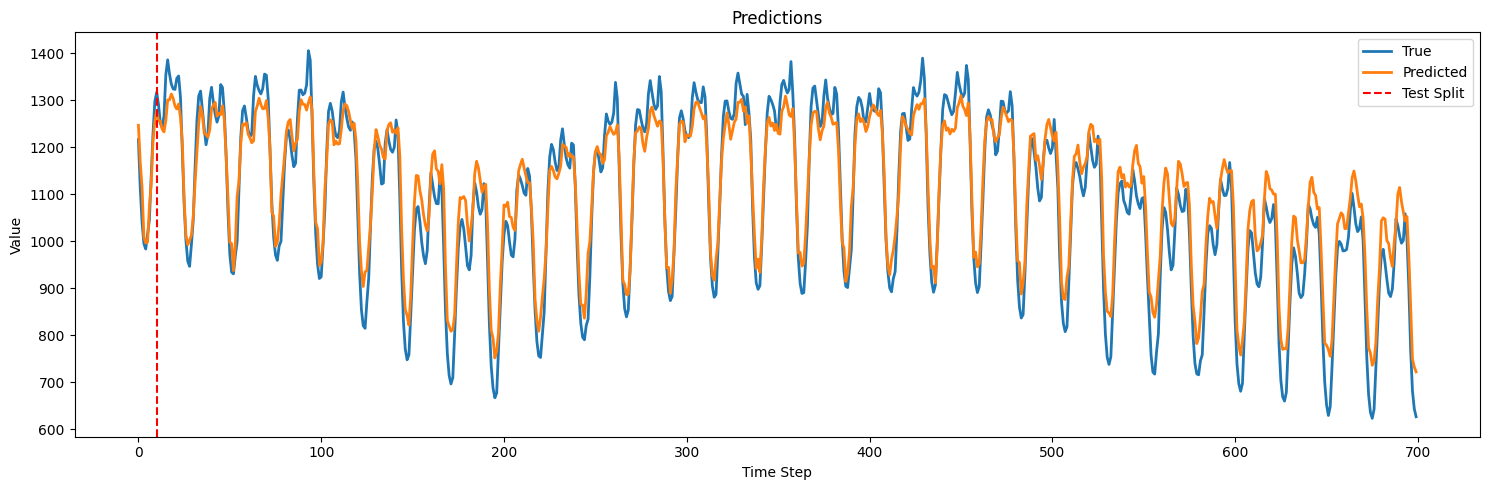

In [129]:
plot_partial_predictions(
    y_true=results['y_true'],
    preds_dict=results['y_pred'],
    split_idx=10,
    group_title="Predictions",
    window_size=700,  # Use the full available length
    start_idx=0
)


In [85]:
print(results['y_pred'])
print(results['y_true'])

[1279.4644  1265.5386  1137.73    ...  700.43414  750.94     618.5533 ]
[1216.0396  1113.44    1039.9702  ...  629.4996   538.6099   439.19977]


In [90]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])     # Take the last time step
        return out
    
lstm_model = LSTM(input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.1)
lstm_model.to(device)
lstm_model, lstm_history = train_model(lstm_model, X_train, y_train, X_val, y_val, epochs=10)

Using device: mps
Starting training...


Epoch 1/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 155.18it/s, Loss=0.175050, Avg Loss=0.001068]


Epoch 1/10 - Train Loss: 0.003800, Val Loss: 0.001072


Epoch 2/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 217.41it/s, Loss=0.172302, Avg Loss=0.000923]


Epoch 2/10 - Train Loss: 0.000339, Val Loss: 0.000927


Epoch 3/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 216.91it/s, Loss=0.173155, Avg Loss=0.000816]


Epoch 3/10 - Train Loss: 0.000230, Val Loss: 0.000819


Epoch 4/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 188.70it/s, Loss=0.173657, Avg Loss=0.000786]


Epoch 4/10 - Train Loss: 0.000146, Val Loss: 0.000789


Epoch 5/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 203.51it/s, Loss=0.172732, Avg Loss=0.000729]


Epoch 5/10 - Train Loss: 0.000109, Val Loss: 0.000732


Epoch 6/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 205.17it/s, Loss=0.171727, Avg Loss=0.000758]


Epoch 6/10 - Train Loss: 0.000097, Val Loss: 0.000761


Epoch 7/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 219.42it/s, Loss=0.171415, Avg Loss=0.000703]


Epoch 7/10 - Train Loss: 0.000088, Val Loss: 0.000706


Epoch 8/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 196.89it/s, Loss=0.171220, Avg Loss=0.000696]


Epoch 8/10 - Train Loss: 0.000078, Val Loss: 0.000698


Epoch 9/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 218.55it/s, Loss=0.171495, Avg Loss=0.000688]


Epoch 9/10 - Train Loss: 0.000071, Val Loss: 0.000691


Epoch 10/10 [Val]: 100%|██████████| 274/274 [00:01<00:00, 216.12it/s, Loss=0.170960, Avg Loss=0.000692]

Epoch 10/10 - Train Loss: 0.000064, Val Loss: 0.000694
Training completed!


Testing: 100%|██████████| 135/135 [00:00<00:00, 301.92it/s]


Before evaluation - all_targets shape: (4320, 1)
Before evaluation - all_preds shape: (4320, 1)
Before evaluation - all_targets range: [-0.693, -0.612]
Before evaluation - all_preds range: [-0.695, -0.623]
Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [311.43, 1418.44]
Debug - After inverse - y_pred range: [291.66, 1266.92]
Test RMSE: 117.82, MAE: 102.23, MAPE: 13.619999885559082%


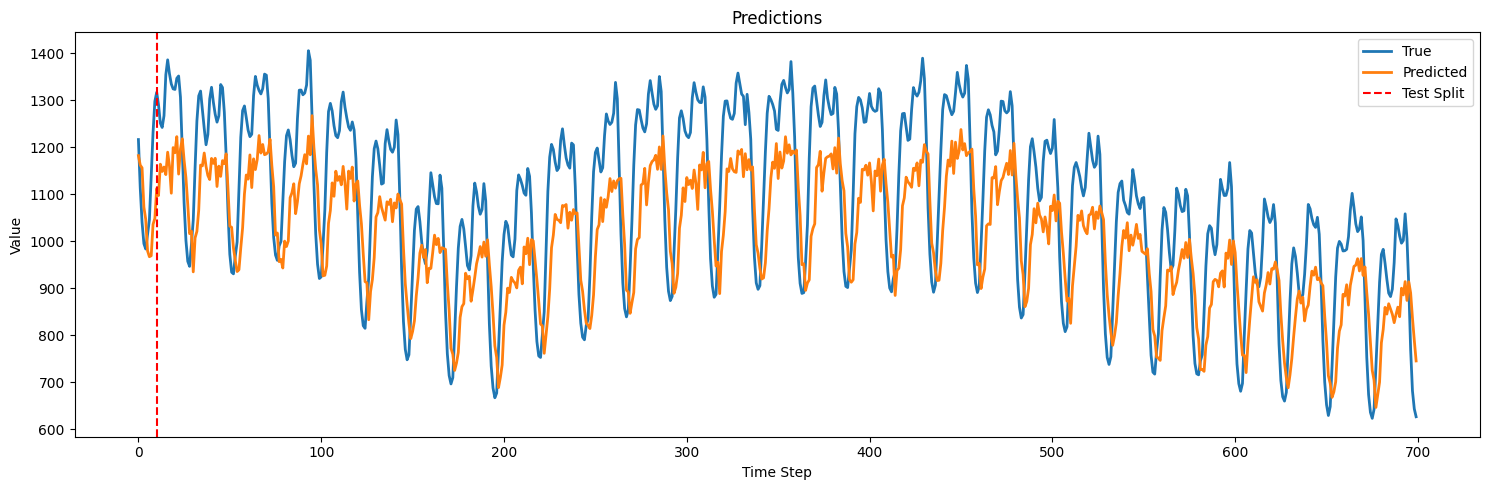

In [91]:
results_lstm = test_model(lstm_model, X_test, y_test, batch_size=32, scaler=scaler)
plot_partial_predictions(
    y_true=results_lstm['y_true'],
    preds_dict=results_lstm['y_pred'],
    split_idx=10,
    group_title="Predictions",
    window_size=700,  # Use the full available length
    start_idx=0
)

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLSTMAttentionV2Large(nn.Module):
    def __init__(self, input_shape, output_len=1, dropout_rate=0.3):
        """
        Fixed version - uses standard pooling instead of adaptive pooling
        """
        super(CNNLSTMAttentionV2Large, self).__init__()
        
        sequence_length, num_features = input_shape
        
        # Calculate proper pooling to avoid dimension issues
        # Start: sequence_length
        # After pool1: sequence_length // 2
        # After pool2: sequence_length // 4
        # After pool3: sequence_length // 8 (using MaxPool instead of Adaptive)
        final_seq_len = sequence_length // 8
        
        # Enhanced CNN Blocks
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(num_features, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),  # sequence_length -> sequence_length // 2
            nn.Dropout(dropout_rate)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),  # sequence_length//2 -> sequence_length // 4
            nn.Dropout(dropout_rate)
        )
        
        # Third CNN block with fixed pooling
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2),  # sequence_length//4 -> sequence_length // 8
            nn.Dropout(dropout_rate)
        )
        
        # Store the final sequence length for LSTM
        self.final_seq_len = final_seq_len
        lstm_input_features = 512
        
        # Deep LSTM layers
        self.lstm1 = nn.LSTM(
            input_size=lstm_input_features,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=False
        )
        
        self.lstm2 = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=False
        )
        
        # Enhanced Attention mechanism
        self.attention = MultiHeadSelfAttention(
            hidden_dim=128,
            num_heads=8,
            dropout=dropout_rate
        )
        
        # Larger dense layers
        self.dense_layers = nn.Sequential(
            nn.Linear(128 * self.final_seq_len, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        
        self.output_layer = nn.Linear(128, output_len)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_features)
        
        # Rearrange for Conv1d: (batch_size, num_features, sequence_length)
        x = x.transpose(1, 2)
        
        # Enhanced CNN Blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        
        # Rearrange back for LSTM: (batch_size, sequence_length, features)
        x = x.transpose(1, 2)
        # Now x shape: (batch_size, sequence_length//8, 512)
        
        # Deep LSTM
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Enhanced Attention
        x = self.attention(x)
        
        # Flatten
        x = x.reshape(x.size(0), -1)
        
        # Dense layers
        x = self.dense_layers(x)
        output = self.output_layer(x)
        
        return output


class MultiHeadSelfAttention(nn.Module):
    """
    Multi-head self-attention mechanism for time series
    """
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        
        assert self.head_dim * num_heads == hidden_dim, "hidden_dim must be divisible by num_heads"
        
        # Linear projections for Q, K, V
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, seq_len, hidden_dim = x.size()
        
        # Linear projections
        Q = self.query(x)  # (batch_size, seq_len, hidden_dim)
        K = self.key(x)    # (batch_size, seq_len, hidden_dim)
        V = self.value(x)  # (batch_size, seq_len, hidden_dim)
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Shapes: (batch_size, num_heads, seq_len, head_dim)
        
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        # scores shape: (batch_size, num_heads, seq_len, seq_len)
        
        # Apply softmax to get attention weights
        attention_weights = self.softmax(scores)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        attended = torch.matmul(attention_weights, V)
        # attended shape: (batch_size, num_heads, seq_len, head_dim)
        
        # Concatenate heads and project
        attended = attended.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_dim)
        output = self.output_proj(attended)
        
        return output


# Simpler version that's guaranteed to work
class CNNLSTMAttentionRobust(nn.Module):
    def __init__(self, input_shape, output_len=1, dropout_rate=0.3):
        """
        Robust version that works with any sequence length
        """
        super(CNNLSTMAttentionRobust, self).__init__()
        
        sequence_length, num_features = input_shape
        
        # CNN Blocks with Global Average Pooling at the end
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(num_features, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_rate)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_rate)
        )
        
        # Global Average Pooling instead of fixed pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # LSTM layers
        self.lstm1 = nn.LSTM(
            input_size=256,  # After global pooling we'll use features directly
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=False
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=128,
            num_heads=8,
            dropout=dropout_rate,
            batch_first=True
        )
        
        # Dense layers
        self.dense_layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        
        self.output_layer = nn.Linear(64, output_len)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_features)
        
        # CNN path
        x_cnn = x.transpose(1, 2)
        x_cnn = self.conv_block1(x_cnn)
        x_cnn = self.conv_block2(x_cnn)
        x_cnn = self.global_pool(x_cnn)  # (batch_size, 256, 1)
        x_cnn = x_cnn.squeeze(-1)        # (batch_size, 256)
        
        # LSTM path (on original sequence)
        x_lstm, _ = self.lstm1(x)        # (batch_size, seq_len, 128)
        x_lstm, _ = self.attention(x_lstm, x_lstm, x_lstm)
        x_lstm = x_lstm[:, -1, :]        # Take last timestep (batch_size, 128)
        
        # Combine both paths
        x_combined = torch.cat([x_cnn, x_lstm], dim=1)  # (batch_size, 256 + 128)
        
        # Dense layers
        x = self.dense_layers(x_combined)
        output = self.output_layer(x)
        
        return output


sequence_length = 24
num_features = 1
output_len = 1
batch_size = 32

# Large model
model_large = CNNLSTMAttentionV2Large(
    input_shape=(sequence_length, num_features),
    output_len=output_len
)

# XL model
# model_xl = CNNLSTMAttentionV2XL(
#     input_shape=(sequence_length, num_features),
#     output_len=output_len
# )



In [104]:
model_cnn_lstm, cnn_lstm_history = train_model(model_large, X_train, y_train, X_val, y_val, epochs=10)


Using device: mps
Starting training...


Epoch 1/10 [Val]: 100%|██████████| 274/274 [00:03<00:00, 73.36it/s, Loss=0.002107, Avg Loss=0.001794]


Epoch 1/10 - Train Loss: 0.108103, Val Loss: 0.001800


Epoch 2/10 [Val]: 100%|██████████| 274/274 [00:03<00:00, 80.94it/s, Loss=0.000100, Avg Loss=0.000575]


Epoch 2/10 - Train Loss: 0.046068, Val Loss: 0.000577


Epoch 3/10 [Val]: 100%|██████████| 274/274 [00:03<00:00, 84.77it/s, Loss=0.000869, Avg Loss=0.000466] 


Epoch 3/10 - Train Loss: 0.022762, Val Loss: 0.000468


Epoch 4/10 [Val]: 100%|██████████| 274/274 [00:04<00:00, 56.54it/s, Loss=0.001261, Avg Loss=0.000339]


Epoch 4/10 - Train Loss: 0.011934, Val Loss: 0.000341


Epoch 5/10 [Val]: 100%|██████████| 274/274 [00:02<00:00, 96.11it/s, Loss=0.000061, Avg Loss=0.001336] 


Epoch 5/10 - Train Loss: 0.007063, Val Loss: 0.001341


Epoch 6/10 [Val]: 100%|██████████| 274/274 [00:02<00:00, 96.41it/s, Loss=0.000316, Avg Loss=0.001400] 


Epoch 6/10 - Train Loss: 0.005176, Val Loss: 0.001406


Epoch 7/10 [Val]: 100%|██████████| 274/274 [00:03<00:00, 69.70it/s, Loss=0.000033, Avg Loss=0.000842] 


Epoch 7/10 - Train Loss: 0.004161, Val Loss: 0.000845


Epoch 8/10 [Val]: 100%|██████████| 274/274 [00:02<00:00, 106.77it/s, Loss=0.000053, Avg Loss=0.002838]


Epoch 8/10 - Train Loss: 0.003495, Val Loss: 0.002848


Epoch 9/10 [Val]: 100%|██████████| 274/274 [00:02<00:00, 111.85it/s, Loss=0.000035, Avg Loss=0.002478]


Epoch 9/10 - Train Loss: 0.002937, Val Loss: 0.002487


Epoch 10/10 [Val]: 100%|██████████| 274/274 [00:03<00:00, 71.70it/s, Loss=0.001933, Avg Loss=0.004465] 


Epoch 10/10 - Train Loss: 0.002475, Val Loss: 0.004482
Training completed!


Testing: 100%|██████████| 135/135 [00:00<00:00, 138.61it/s]


Before evaluation - all_targets shape: (4320, 1)
Before evaluation - all_preds shape: (4320, 1)
Before evaluation - all_targets range: [-0.693, -0.612]
Before evaluation - all_preds range: [-0.691, -0.516]
Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [311.43, 1418.44]
Debug - After inverse - y_pred range: [341.29, 2726.98]
Test RMSE: 1000.97, MAE: 896.24, MAPE: 123.4800033569336%


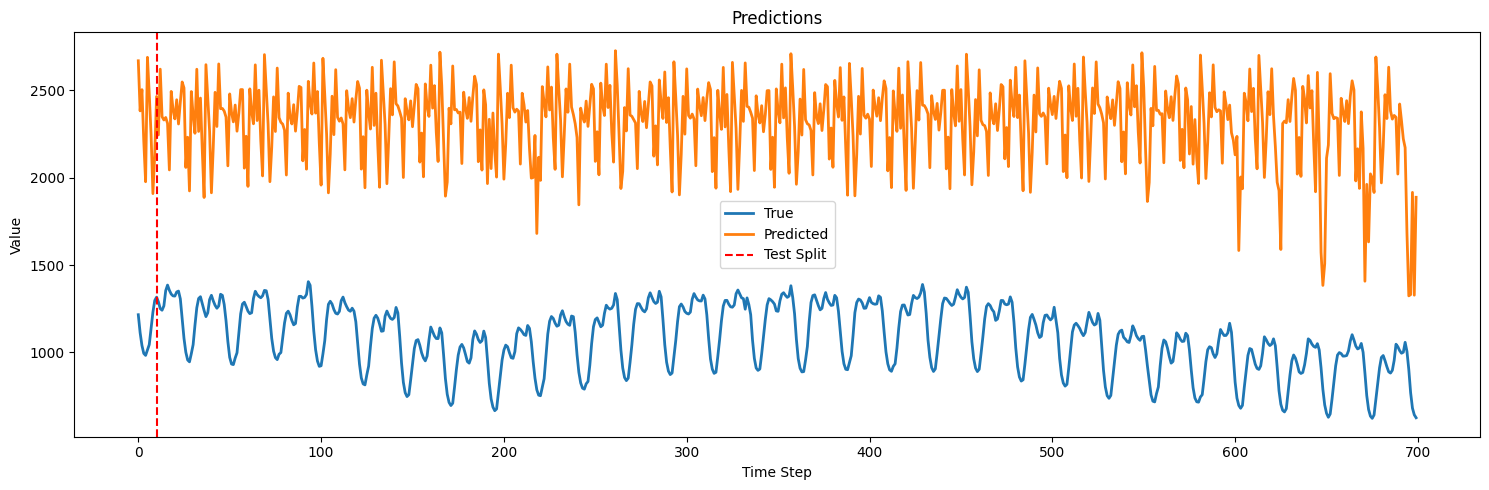

In [106]:
results_cnn_lstm = test_model(model_large, X_test, y_test, batch_size=32, scaler=scaler)
plot_partial_predictions(
    y_true=results_cnn_lstm['y_true'],
    preds_dict=results_cnn_lstm['y_pred'],
    split_idx=10,
    group_title="Predictions",
    window_size=700,  # Use the full available length
    start_idx=0
)

In [31]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class GLU(nn.Module):
    """Gated Linear Unit used as gating non-linearity."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features * 2)
        
    def forward(self, x):
        x_proj = self.fc(x)
        a, b = x_proj.chunk(2, dim=-1)
        return a * torch.sigmoid(b)

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=None, dropout=0.1, context_size=None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

        self.context_fc = nn.Linear(context_size, hidden_size) if context_size is not None else None
        self.gate = nn.Linear(output_size, output_size)
        self.skip = nn.Linear(input_size, output_size) if input_size != output_size else None
        self.layer_norm = nn.LayerNorm(output_size)

    def forward(self, x, context=None):
        """
        x: (B, T, input_size) or (B, input_size)
        context: (B, context_size) or (B, T, context_size)
        """
        residual = x
        
        # Handle different input dimensions
        if x.dim() == 3:  # (B, T, D)
            B, T, D = x.shape
            x_flat = x.reshape(B * T, D)
            if context is not None and self.context_fc is not None:
                if context.dim() == 2:  # (B, context_size)
                    context = context.unsqueeze(1).expand(B, T, -1).reshape(B * T, -1)
                elif context.dim() == 3:  # (B, T, context_size)
                    context = context.reshape(B * T, -1)
        else:
            x_flat = x
            if context is not None and self.context_fc is not None:
                context = context

        x_fc = self.fc1(x_flat)

        if context is not None and self.context_fc is not None:
            context_proj = self.context_fc(context)
            x_fc = x_fc + context_proj

        x_fc = self.elu(x_fc)
        x_fc = self.fc2(x_fc)
        x_fc = self.dropout(x_fc)

        gated = torch.sigmoid(self.gate(x_fc)) * x_fc

        if x.dim() == 3:
            gated = gated.reshape(B, T, -1)
            residual = residual.reshape(B, T, -1)

        if self.skip is not None:
            residual = self.skip(residual)
            
        output = gated + residual
        return self.layer_norm(output)


class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, context_size=None, dropout=0.1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.context_size = context_size
        
        # GRN for variable selection weights
        self.selection_grn = GatedResidualNetwork(
            input_size, hidden_size, output_size=input_size,
            dropout=dropout, context_size=context_size
        )
        
        # Projection to hidden size
        self.project = nn.Linear(input_size, hidden_size)
        
    def forward(self, x, context=None):
        # x: (B, T, input_size)
        # context: (B, context_size) or None
        
        B, T, D = x.shape
        
        # Get selection weights
        if context is not None and self.context_size is not None:
            # Expand context to match temporal dimension
            if context.dim() == 2:
                context_expanded = context.unsqueeze(1).expand(B, T, -1)
            else:
                context_expanded = context
        else:
            context_expanded = None
            
        # Get selection weights (B, T, input_size)
        selection_weights = self.selection_grn(x, context_expanded)
        selection_weights = F.softmax(selection_weights, dim=-1)
        
        # Apply selection and project
        selected = selection_weights * x
        projected = self.project(selected)  # (B, T, hidden_size)
        
        return projected, selection_weights


class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
        
    def forward(self, q, k, v, attn_mask=None):
        # q: (B, T_q, d_model), k/v: (B, T_k, d_model)
        B, T_q, _ = q.shape
        T_k = k.shape[1]
        
        # Project and reshape for multi-head attention
        q = self.q_proj(q).view(B, T_q, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(k).view(B, T_k, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(v).view(B, T_k, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale  # (B, H, T_q, T_k)
        
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == 0, float('-inf'))
            
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        context = torch.matmul(attn_weights, v)  # (B, H, T_q, d_h)
        context = context.transpose(1, 2).contiguous().view(B, T_q, self.d_model)
        
        # Output projection
        output = self.out_proj(context)
        return output, attn_weights

class TemporalFusionDecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.attn = InterpretableMultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.attn_gating = nn.Linear(d_model, d_model)
        self.attn_res_norm = nn.LayerNorm(d_model)
        
        # Position-wise feed-forward
        self.post_grn = GatedResidualNetwork(d_model, d_model, output_size=d_model, dropout=dropout)
        
    def forward(self, x, memory, attn_mask=None):
        # x: (B, T_out, d_model), memory: (B, T_mem, d_model)
        
        # Cross-attention
        attended, attn_scores = self.attn(x, memory, memory, attn_mask=attn_mask)
        
        # Gating + residual + layer norm
        gated = torch.sigmoid(self.attn_gating(attended)) * attended
        x = self.attn_res_norm(x + gated)
        
        # Position-wise GRN
        x = self.post_grn(x)
        
        return x, attn_scores

class TrendExtractionBranch(nn.Module):
    """CNN-based branch for multi-scale trend extraction"""
    def __init__(self, input_size, hidden_size, conv_kernels=[3, 7, 15], dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.conv_kernels = conv_kernels
        self.num_kernels = len(conv_kernels)
        
        # Calculate output channels
        base_channels = hidden_size // self.num_kernels
        remainder = hidden_size % self.num_kernels
        self.output_channels = [base_channels + (1 if i < remainder else 0) 
                              for i in range(self.num_kernels)]
        
        # Parallel convolutional layers
        self.conv_layers = nn.ModuleList()
        for i, kernel_size in enumerate(conv_kernels):
            padding = (kernel_size - 1) // 2
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=input_size, out_channels=self.output_channels[i],
                         kernel_size=kernel_size, padding=padding, padding_mode='replicate'),
                nn.BatchNorm1d(self.output_channels[i]),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.conv_layers.append(conv_block)
        
        # Global pooling and projection
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.feature_projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_size)
        )
        
    def forward(self, x):
        # x: (B, T, input_size)
        x_conv = x.transpose(1, 2)  # (B, input_size, T)
        
        # Apply parallel convolutions
        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_out = conv_layer(x_conv)  # (B, out_ch_i, T)
            conv_outputs.append(conv_out)
        
        # Concatenate along channel dimension
        combined = torch.cat(conv_outputs, dim=1)  # (B, hidden_size, T)
        
        # Temporal trend map
        temporal_map = combined.transpose(1, 2)  # (B, T, hidden_size)
        
        # Global pooled trend (static representation)
        pooled = self.global_pool(combined).squeeze(-1)  # (B, hidden_size)
        projected = self.feature_projection(pooled)  # (B, hidden_size)
        
        return temporal_map, projected

class TFTWithTrendTraining(nn.Module):
    def __init__(self, sequence_length, prediction_length, input_size=1, hidden_size=128,
                 num_lstm_layers=1, dropout=0.1, conv_kernels=[3, 7, 15], num_attention_heads=4):
        super().__init__()
        # Same initialization as before
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # All the same components...
        self.trend_branch = TrendExtractionBranch(
            input_size=input_size, hidden_size=hidden_size,
            conv_kernels=conv_kernels, dropout=dropout
        )
        
        self.var_selector = VariableSelectionNetwork(
            input_size=input_size, hidden_size=hidden_size,
            context_size=hidden_size, dropout=dropout
        )
        
        self.static_context_enricher = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size)
        )
        
        self.encoder_lstm = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size,
            num_layers=num_lstm_layers, batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0
        )
        
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size,
            num_layers=num_lstm_layers, batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0
        )
        
        self.static_enrichment_grn = GatedResidualNetwork(
            hidden_size, hidden_size, output_size=hidden_size,
            dropout=dropout, context_size=hidden_size
        )
        
        self.temporal_decoder_block = TemporalFusionDecoderBlock(
            d_model=hidden_size, num_heads=num_attention_heads, dropout=dropout
        )
        
        self.post_grn = GatedResidualNetwork(
            hidden_size, hidden_size, output_size=hidden_size, dropout=dropout
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, prediction_length)
        )
        
    def forward(self, x, return_interpretability=False):
        """
        x: (B, sequence_length, input_size)
        return_interpretability: if True, return tuple (output, interpretability_dict)
                                if False, return only output
        """
        B, T, C = x.shape
        assert T == self.sequence_length
        
        # Forward pass (same as before)
        trend_temporal_map, trend_static = self.trend_branch(x)
        projected_inputs, selection_weights = self.var_selector(x, context=trend_static)
        enc_out, (h_n, c_n) = self.encoder_lstm(projected_inputs)
        static_context = self.static_context_enricher(trend_static)
        static_context_expanded = static_context.unsqueeze(1).expand(B, T, self.hidden_size)
        enc_enriched = self.static_enrichment_grn(enc_out, context=static_context_expanded)
        decoder_start = enc_enriched[:, -1:, :]
        decoder_inputs = decoder_start.repeat(1, self.prediction_length, 1)
        dec_out, _ = self.decoder_lstm(decoder_inputs)
        memory = enc_enriched + trend_temporal_map
        fused_dec, attn_scores = self.temporal_decoder_block(dec_out, memory)
        
        if self.prediction_length > 1:
            final_rep = fused_dec.mean(dim=1)
        else:
            final_rep = fused_dec.squeeze(1)
            
        final_rep = self.post_grn(final_rep)
        output = self.output_layer(final_rep)
        
        if return_interpretability:
            return output, {
                "selection_weights": selection_weights,
                "attention_scores": attn_scores,
                "trend_static": trend_static
            }
        else:
            return output

# Use this version for training
model_tft = TFTWithTrendTraining(
    sequence_length=24, 
    prediction_length=1,
    input_size=1, 
    hidden_size=128, 
    num_lstm_layers=2,
    dropout=0.1, 
    conv_kernels=[3, 7, 15], 
    num_attention_heads=4
)



In [37]:
model_tft, tft_history = train_model(model_tft, X_train, y_train, X_val, y_val, epochs=15)

Using device: mps
Starting training...


Epoch 1/15 [Train]:   0%|          | 200/51538 [00:03<15:42, 54.45it/s, Loss=0.056597, Avg Loss=0.174891]


KeyboardInterrupt: 

In [9]:
torch.save(model_tft.state_dict(),"model_tft.pth")

In [12]:
scaler = MinMaxScaler()
scaler = joblib.load("scaler_minmax.pkl")

Testing: 100%|███████████████████████████████| 135/135 [00:00<00:00, 178.52it/s]

Before evaluation - all_targets shape: (4320, 1)
Before evaluation - all_preds shape: (4320, 1)
Before evaluation - all_targets range: [311.430, 1418.440]
Before evaluation - all_preds range: [-0.403, -0.021]
Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [27460028.00, 125069520.00]
Debug - After inverse - y_pred range: [-35525.25, -1891.62]
Test RMSE: 73359066.81, MAE: 69702360.0, MAPE: 100.02999877929688%


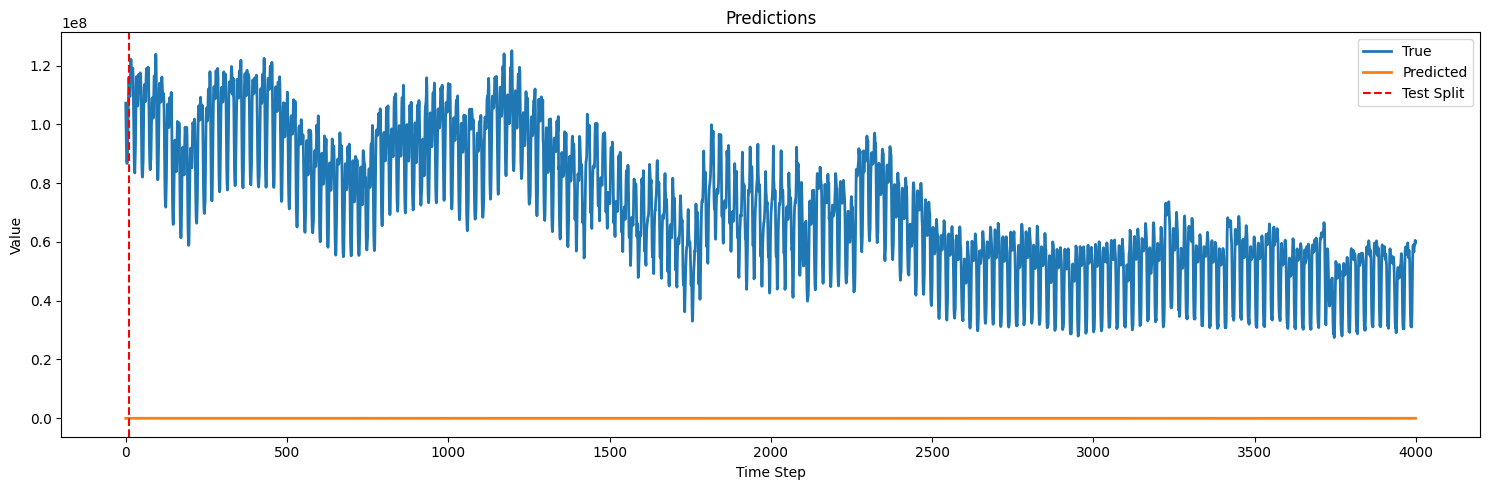

In [13]:
results_tft = test_model(model_tft, X_test, y_test, batch_size=32, scaler=scaler)
plot_partial_predictions(
    y_true=results_tft['y_true'],
    preds_dict=results_tft['y_pred'],
    split_idx=10,
    group_title="Predictions",
    window_size=4000,  # Use the full available length
    start_idx=0
)

In [ ]:
def test_model_per_country(model, df, sequence_length=24, prediction_length=1, batch_size=32):
    """
    Test the model for each country using its own saved StandardScaler.
    """
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    countries = df['CountryCode'].unique()
    results_dict = {}

    for country in countries:
        country_df = df[df['CountryCode'] == country].copy()
        scaler_path = f"scaler_{country}.pkl"
        try:
            scaler = joblib.load(scaler_path)
        except FileNotFoundError:
            print(f"Scaler for {country} not found. Skipping.")
            continue

        # Prepare sequences for this country
        X_test, y_test = prepare_multi_country_data_per_country_scaler(
            country_df, sequence_length=sequence_length, prediction_length=prediction_length, dataset_name="test"
        )
        if len(X_test) == 0:
            print(f"Skipping {country}: Not enough data for sequence_length={sequence_length}")
            continue

        # Convert to tensors
        if isinstance(X_test, np.ndarray):
            X_test = torch.FloatTensor(X_test)
        if isinstance(y_test, np.ndarray):
            y_test = torch.FloatTensor(y_test)

        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f'Testing {country}'):
                data, target = data.to(device), target.to(device)
                if len(data.shape) == 2:
                    data = data.unsqueeze(-1)
                output = model(data)
                all_preds.append(output.cpu().numpy())
                all_targets.append(target.cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # Inverse transform using country scaler
        rmse, mae, mape, y_true_inv, y_pred_inv = evaluate_model(all_targets, all_preds, scaler=scaler)
        print(f"{country} - RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")

        results_dict[country] = {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'y_true': y_true_inv,
            'y_pred': y_pred_inv
        }

    return results_dict

In [36]:
test_model_per_country(model=model_tft, df=test_df, sequence_length=24, prediction_length=1)

NameError: name 'test_model_per_country' is not defined